# Mentoría 'de cómo clasificar en géneros a las canciones'
## Práctico IV : Aprendizaje no supervisado

**Antes de empezar:**
- [Instalar spaCy y el modelo de lenguaje con el que van a trabajar](https://spacy.io/models#quickstart)

**Consideraciones:**
- Se evalúa el estilo y prolijidad del código.
- Se permite hacer trabajo extra, siempre y cuando las actividades básicas estén resueltas.

**Recomendación:**
- Hay muchos ejemplos de código en internet, no se sientan obligados a implementar todo desde cero.
- La cantidad de líneas de código del esqueleto no es estricta, pueden completarlo con más (o menos) líneas.

### Librerías

In [ ]:
#!pip3 install spotipy
#!pip3 install pandas
#!pip3 install spacy
#!pip3 install pymusixmatch
#!pip3 install nltk
#!pip3 install sklearn

# Agregar las librerías extra que se utilicen en esta celda y la siguiente

### Dependencias y acceso a APIs

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import StandardScaler

#import spotipy
#import spacy
#from spotipy.oauth2 import SpotifyClientCredentials
#from musixmatch import Musixmatch

#client_id = '46b333d567314a89a6254b6c6b054be6'
#client_secret = '9d922c3613e441518349dcf55f7d5853'
#client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)

#nlp = spacy.load("en_core_web_sm") # completar con el modelo que van a utilizar

#sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)
#musixmatch = Musixmatch('1aa5272f4402bf2f082ad2f3958c2c62') # se puede reemplazar por otra API si da mejores resultados

In [ ]:
pd.set_option('max_rows', 99999)
pd.set_option('max_colwidth', 400)
pd.describe_option('max_colwidth')

display.max_colwidth : int or None
    The maximum width in characters of a column in the repr of
    a pandas data structure. When the column overflows, a "..."
    placeholder is embedded in the output. A 'None' value means unlimited.
    [default: 50] [currently: 400]


### Funciones para gráficos
Estas funciones se utilizarán __sólo en el inciso 4)__

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

def plot2D(title, X, colors):
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111)
    scatter = ax.scatter(X[:, 0], X[:, 1], c=colors)
    plt.xlim(-50, 200)
    plt.ylim(-50, 170)
    ax.set_title(title)
    ax.set_xlabel('First component')
    ax.set_ylabel('Second Component')
    plt.colorbar(scatter);
    plt.plot()
    
def plot3D(title, X, colors):
    fig = plt.figure(figsize=(12, 8))
    #ax = fig.add_subplot(111, projection='3d')
    ax = Axes3D(fig)
    scatter = ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=colors)
    plt.xlim(-50, 200)
    plt.ylim(-50, 170)
    ax.set_title(title)
    ax.set_xlabel('First component')
    ax.set_ylabel('Second component')
    ax.set_zlabel('Third component')
    plt.colorbar(scatter)
    #plt.plot()

### 1) Recopilar los datos obtenidos en los prácticos anteriores

Para esta parte consideraremos [la playlist colaborativa de la mentoría](https://open.spotify.com/playlist/2IuD0qZb14cji5y52crdsO?si=nfHRPDquQRyotEcXc4tG7Q), de esta obtendremos:
- Las features del audio de las canciones
- Las features textuales de sus letras

Además es necesario aplicar el mismo preprocesamiento que aplicamos en los prácticos anteriores para ambos tipos de features (el preprocesamiento del p1 a las features de audio y el de p2 al de features textuales). En este caso la etiqueta no se utilizará para el proceso de clasificación dada la naturaleza no supervisada de nuestro clasificador.

Luego, se obtendrá como resultado el conjunto de variables X.

La última tarea de este inciso será aplicar escalado estándar a las features de X. La estandarización consiste en  reescalar las features de modo que estas tengan las propiedades de una [distribución normal](https://es.wikipedia.org/wiki/Distribuci%C3%B3n_normal) estándar (media = 0 y desviación estándar = 1). Esta tarea es [importante](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_scaling_importance.html) en nuestro caso, ya que permite una mejor visualización de los clusters obtenidos por nuestro algoritmo.

**Recomendaciones:**
- Obtener las features por separado y hacer un join de los datasets.
- Prestar atención a la [documentación de sklearn](https://scikit-learn.org/stable/)
- Si usan features categóricas, ENCODEARLAS!

---------------------
Utilizando los datos obtenidos y preprocesados de los prácticos anteriores cargamos el dataframe (No se vuelve a describir el proceso porque se lo explicó en las entregas anteriores)

In [ ]:
df = pd.read_csv('df_with_sentiment_bruto.csv', index_col=0)

FileNotFoundError: ignored

In [ ]:
df = df[df['most_common_genre'].isin(['argentine rock', 'latin', 'cuarteto', 'cumbia villera', 'argentine indie'])]
df.most_common_genre.value_counts()

NameError: ignored

Habiendo hecho una selección de las features mas relevantes para este trabajo decidimos quedarnos sólamente con las cuantro características descritas a continuación. Estas nos permitieron dividir en clusters mas representativos, y que tenían mas sentido a nivel musical o semántico.

In [ ]:
#features = ['danceability', 'energy', 'key', 'loudness', 'mode', 
#            'speechiness', 'acousticness', 'instrumentalness', 'valence',
#            'tempo', 'duration_ms', 'time_signature', 
#            'min_lyrics_sentiment', 'max_lyrics_sentiment', 'avg_lyrics_sentiment']   

features = ['danceability', 'energy', 'loudness', 'valence']   

df_f = df[features]
df_f

NameError: ignored

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_f)
X_scaled

NameError: ignored

### 2) Elegir un número óptimo de clusters

En este punto buscaremos el número de clusters que queremos para correr K-means obteniendo los mejores resultados. Para esto utilizaremos dos criterios de selección:
- Primero, el "método del codo" (Elbow method). Este es una técnica (heurística) muy popular en el aprendizaje no supervisado que consiste en correr el algoritmo con diferentes cantidades __k__ de clusters, calculando para cada caso la suma de distancias cuadradas de cada punto al centro asignado para su cluster (PISTA: estos valores se pueden obtener como un atributo del clasificador luego de ajustarlo a __X_scaled__). Luego graficamos para cada __k__ el valor obtenido, esto nos dará un gráfico con forma de brazo (curva) en el cual el codo del mismo (el punto de inflexión de la curva) es un buen valor para __k__.
- Segundo, el [Silhouette Score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html) nos da un coeficiente que va de -1 (peor) a 1 (mejor) y que nos dice qué tan similar es un punto a los demás dentro de su cluster y qué tan diferente es de los puntos en el resto de los clusters. En este caso nos quedaremos con el valor de k que maximice el Silhouette score para __X_scaled__.

La tarea consiste en obtener para cada caso el k que de mejores resultados de acuerdo a los gráficos obtenidos.

In [ ]:
# Preparamos una lista donde vamos a ir agregando las distancias medias y silhouette
lista_distancias_medias = []
lista_sil = []
# Entrenamos un modelo para cada numero de cluster que queremos testear
min_n_clusters = 2
max_n_clusters = 8
# Puede agregar saltos en el intervalo si las corridas demoran demasiado o definir su propio intervalo.
n_clusters = range(min_n_clusters, max_n_clusters)

for k in n_clusters:
    # Definimos y entrenamos el modelo
    km = KMeans(n_clusters=k)
    km = km.fit(X_scaled)
    # Tomamos la suma de las distancias para todas las instancias del dataset
    distancia_total = km.inertia_
    # Calculamos la distancia media y agregamos a la lista
    distancia_media = np.divide(distancia_total, X_scaled.shape[0])
    lista_distancias_medias.append(distancia_media)
    # Tomamos las etiquetas
    etiquetas = km.labels_
    # Calculamos el silhouette 
    valor_medio_sil = silhouette_score(X_scaled, etiquetas)
    lista_sil.append(valor_medio_sil)


NameError: ignored

ValueError: ignored

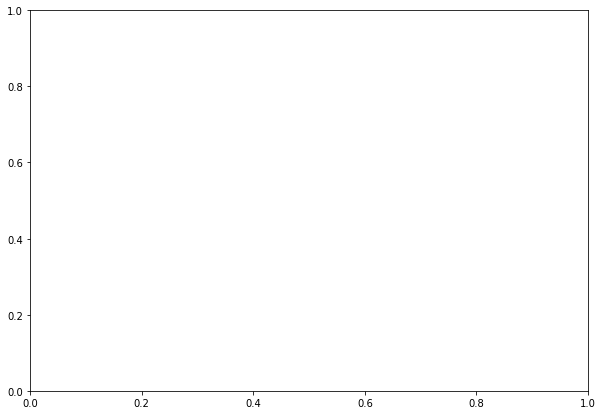

In [ ]:
plt.figure(figsize = (10,7))
# Graficamos una linea continua y tambien unos puntos para resaltar los valores enteros de K.
plt.plot(n_clusters, lista_distancias_medias, lw=3)
plt.scatter(n_clusters, lista_distancias_medias ,s=55,c='r')
plt.xlabel('Cantidad de Clusters K')
plt.ylabel('Inercia media')
plt.title('Método del codo para el Dataset')

plt.show()

ValueError: ignored

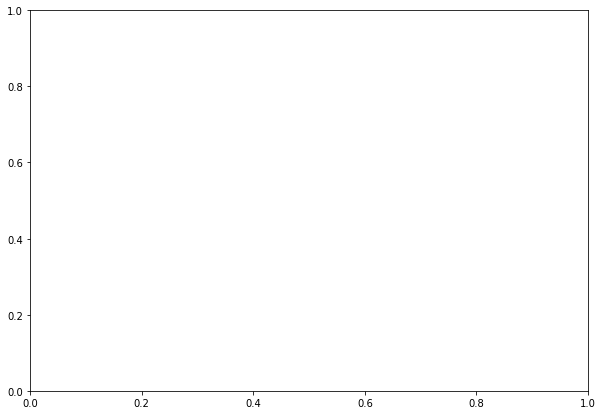

In [ ]:
plt.figure(figsize = (10,7))
plt.plot(n_clusters, lista_sil, lw=3)
plt.scatter(n_clusters, lista_sil,s=55,c='r')
plt.xlabel('Cantidad de Clusters K')
plt.ylabel('Silhouette media')
plt.title('Silhouette media para el Dataset')

plt.show()

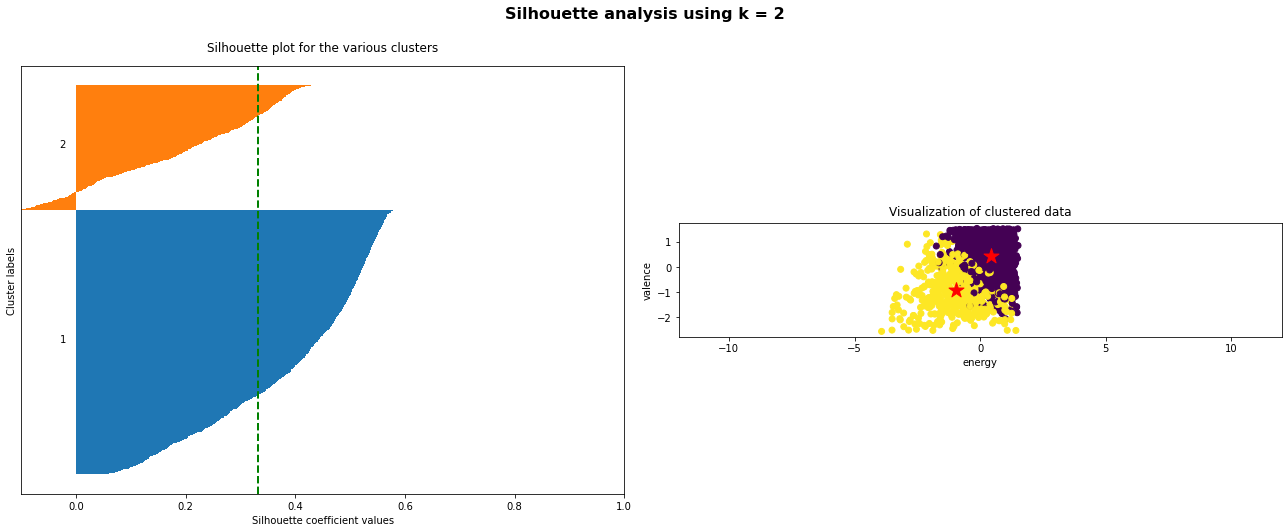

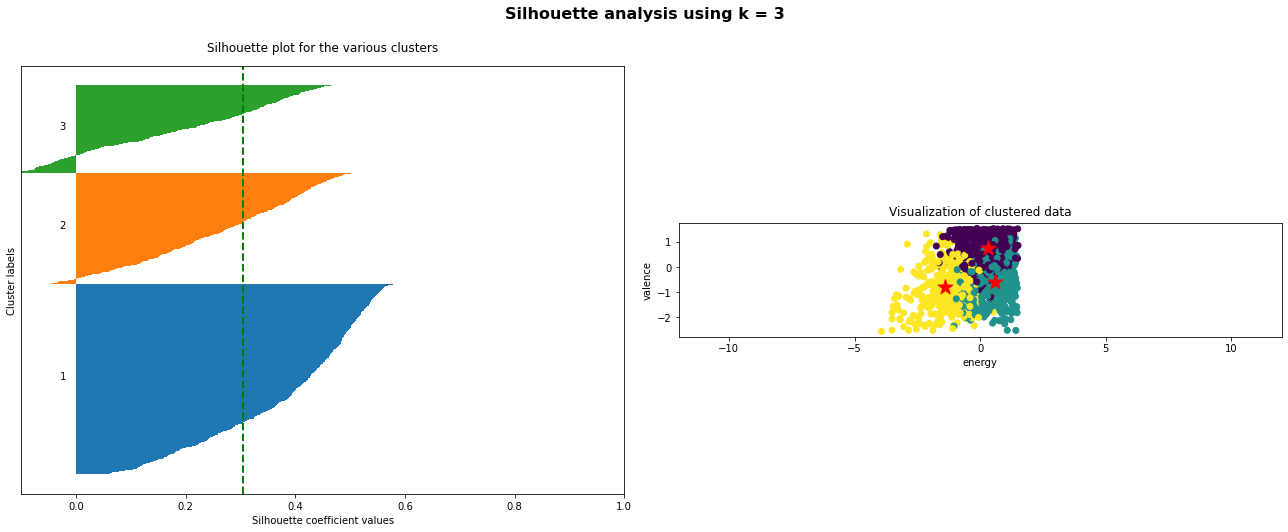

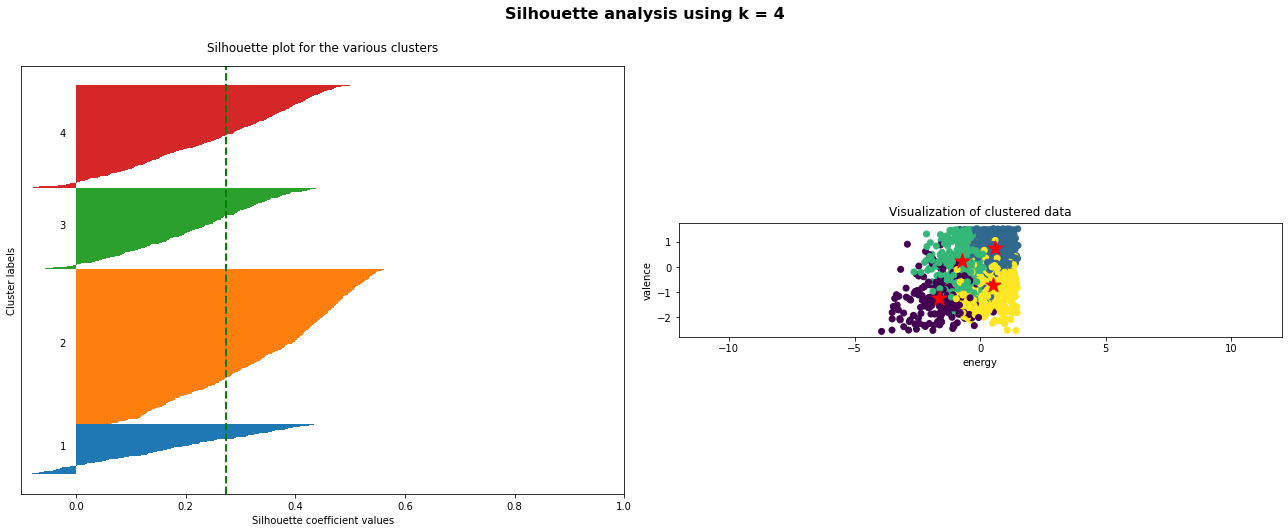

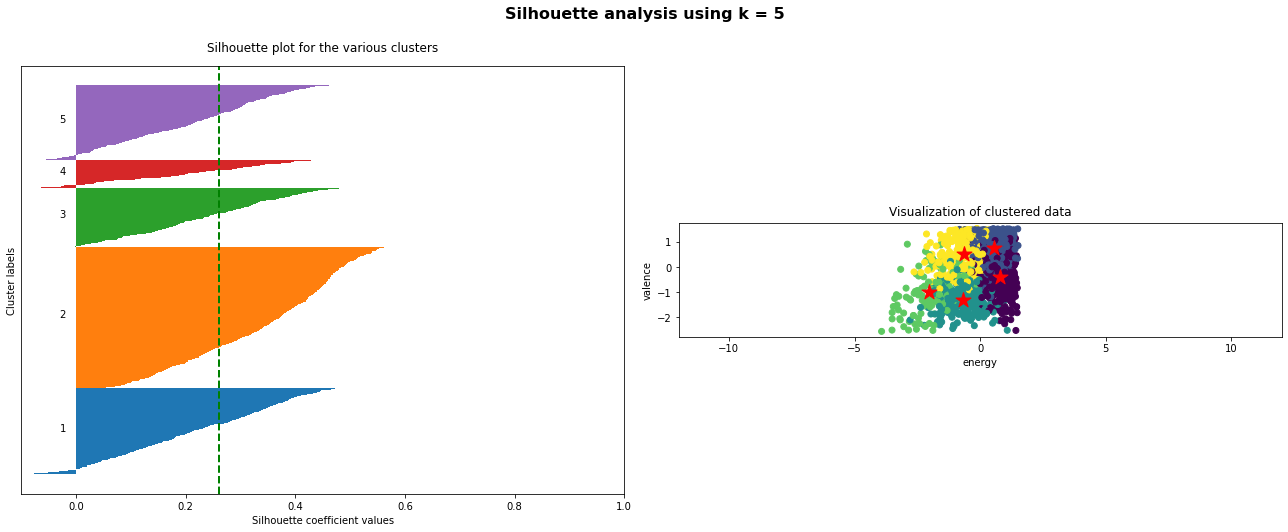

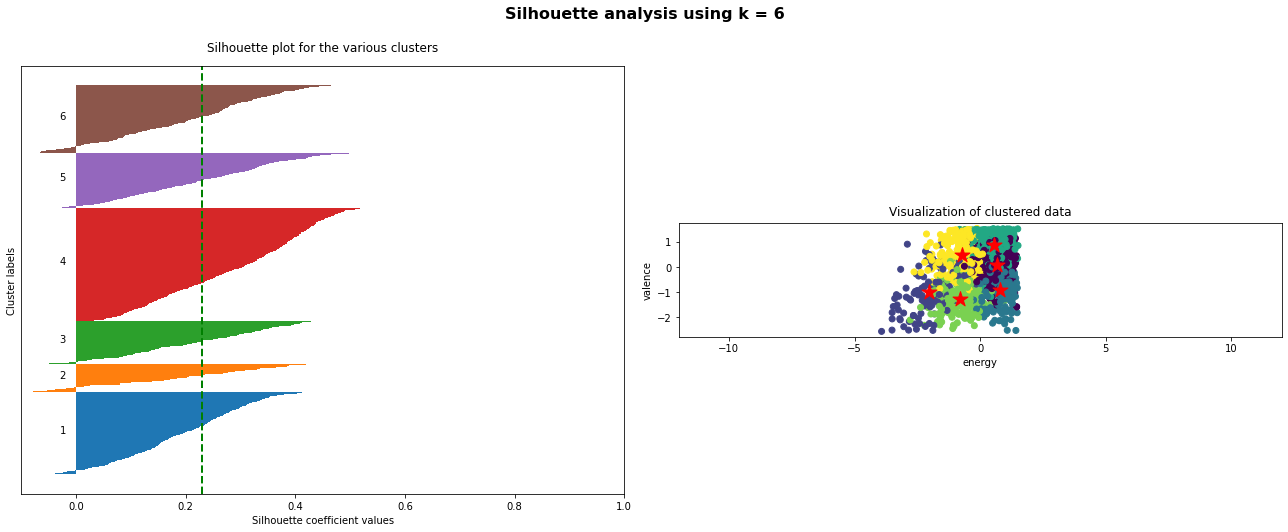

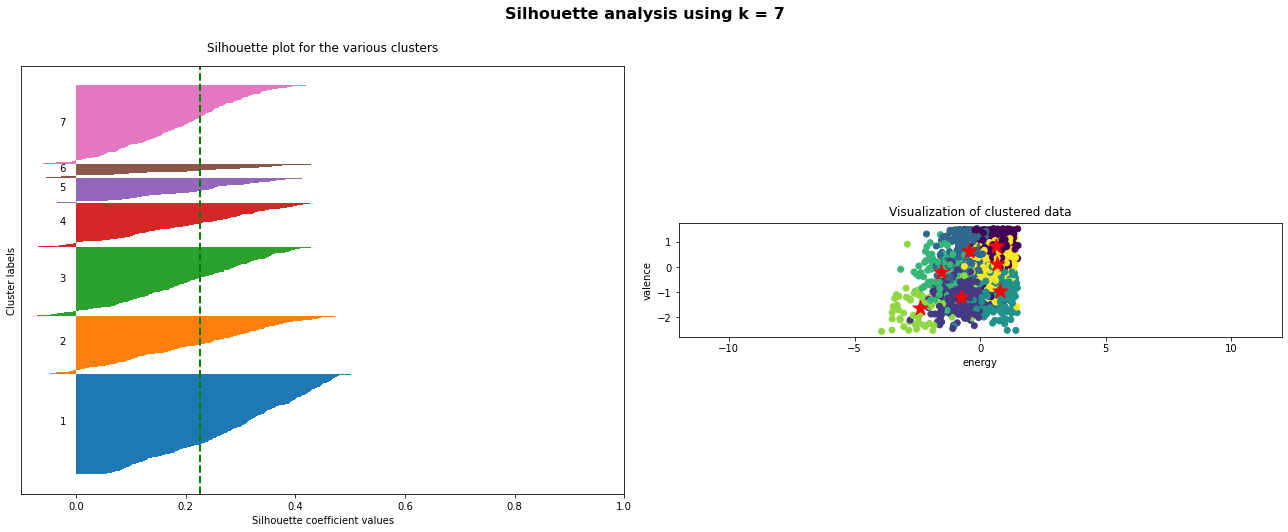

In [ ]:
#X_std = X.to_numpy()
X_std = X_scaled
# lista de clusters
lista_k = [2, 3, 4, 5, 6]

for i, k in enumerate(lista_k):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    
    # Run the Kmeans algorithm
    km = KMeans(n_clusters=k)
    labels = km.fit_predict(X_std)
    centroids = km.cluster_centers_

    # Get silhouette samples
    silhouette_vals = silhouette_samples(X_std, labels)

    # Silhouette plot
    y_ticks = []
    y_lower, y_upper = 0, 0
    for i, cluster in enumerate(np.unique(labels)):
        cluster_silhouette_vals = silhouette_vals[labels == cluster]
        cluster_silhouette_vals.sort()
        y_upper += len(cluster_silhouette_vals)
        ax1.barh(range(y_lower, y_upper), cluster_silhouette_vals, edgecolor='none', height=1)
        ax1.text(-0.03, (y_lower + y_upper) / 2, str(i + 1))
        y_lower += len(cluster_silhouette_vals)

    # Get the average silhouette score and plot it
    avg_score = np.mean(silhouette_vals)
    ax1.axvline(avg_score, linestyle='--', linewidth=2, color='green')
    ax1.set_yticks([])
    ax1.set_xlim([-0.1, 1])
    ax1.set_xlabel('Silhouette coefficient values')
    ax1.set_ylabel('Cluster labels')
    ax1.set_title('Silhouette plot for the various clusters', y=1.02);
    
    # Scatter plot of data colored with labels
    ax2.scatter(X_std[:, 1], X_std[:, 3], c=labels)
    ax2.scatter(centroids[:, 1], centroids[:, 3], marker='*', c='r', s=250)
    ax2.set_xlim([-12, 12])
    ax2.set_xlim([-12, 12])
    ax2.set_xlabel(features[1])
    ax2.set_ylabel(features[3])
    ax2.set_title('Visualization of clustered data', y=1.02)
    ax2.set_aspect('equal')
    plt.tight_layout()
    plt.suptitle(f'Silhouette analysis using k = {k}',
                 fontsize=16, fontweight='semibold', y=1.05);

Los valores de k elegidos de acuerdo a estas dos reglas son:
- k1 = 2
- k2 = 3

Observando estas gráficas podemos inferir que la cantidad óptima de clusters es de 2 o 3, pero este valor también está supeditado a que tan útil o intuitivo sea a nivel musical o semántico (segun los géneros)

### 3) Correr K-Means con los k elegidos

En este punto corremos de nuevo el algoritmo con los __k1__ y __k2__ elegidos en __2)__ y almacenaremos los resultados obtenidos en __X_preds_k1__ y __X_preds_k2__. Recuerden que el output de la predicción es un conjunto de __n__ (= #Canciones) etiquetas que nos dicen en qué cluster está cada canción __Xi__, por lo que deberán crear una tabla o mecanismo para obtener, además de las predicciones, los clusters como listas de canciones para cada __k__ elegido para su posterior análisis en el informe.

In [ ]:
k1 = 2
k2 = 3
km1 = KMeans(n_clusters=k1)
km2 = KMeans(n_clusters=k2)

X_preds_k1 = km1.fit_predict(X_scaled)
X_preds_k2 = km2.fit_predict(X_scaled)

song_clusters_k1 = df.copy()
song_clusters_k1['cluster'] = X_preds_k1
song_clusters_k2 = df.copy()
song_clusters_k2['cluster'] = X_preds_k2

In [ ]:
song_clusters_k1

danceability  energy  ...  avg_lyrics_sentiment  cluster
3            0.499  0.6480  ...                0.4776        1
4            0.528  0.3830  ...                0.4901        1
5            0.330  0.5740  ...                0.4352        1
6            0.406  0.9470  ...                0.4828        1
7            0.577  0.8500  ...                0.4652        0
9            0.467  0.8910  ...                0.4662        0
10           0.475  0.8640  ...                0.5047        0
13           0.298  0.8560  ...                0.5047        0
14           0.385  0.9020  ...                0.5047        0
18           0.897  0.5170  ...                0.5047        0
19           0.492  0.8240  ...                0.5047        0
20           0.772  0.7620  ...                0.5047        0
21           0.576  0.9320  ...                0.4496        0
22           0.593  0.8380  ...                0.5047        0
23           0.200  0.9890  ...                0.5047        0
24           0.771  0.8520  ...                0.4188        0
25           0.662  0.8130  ...                0.5047        0
26           0.773  0.9180  ...                0.5047        0
27           0.747  0.9070  ...                0.3998        0
29           0.485  0.7910  ...                0.4852        1
30           0.714  0.7350  ...                0.4662        0
31           0.724  0.8560  ...                0.4260        0
32           0.486  0.7640  ...                0.4856        0
33           0.596  0.8300  ...                0.3923        0
34           0.557  0.9420  ...                0.5047        0
35           0.172  0.9520  ...                0.4553        0
39           0.555  0.7380  ...                0.5047        0
40           0.472  0.9060  ...                0.5047        0
41           0.321  0.8500  ...                0.5047        0
43           0.781  0.8540  ...                0.5047        0
44           0.779  0.9520  ...                0.5047        0
45           0.614  0.7020  ...                0.5012        0
46           0.764  0.5210  ...                0.5047        1
49           0.765  0.2970  ...                0.5047        1
50           0.674  0.1160  ...                0.5047        1
51           0.805  0.4540  ...                0.5047        1
52           0.531  0.2770  ...                0.5047        1
54           0.702  0.7780  ...                0.5047        0
55           0.668  0.8670  ...                0.5047        0
56           0.765  0.7540  ...                0.4274        0
57           0.716  0.9040  ...                0.5047        0
58           0.504  0.6920  ...                0.5047        1
62           0.786  0.6040  ...                0.4944        0
63           0.830  0.8680  ...                0.5047        0
64           0.772  0.8060  ...                0.4540        0
65           0.671  0.8070  ...                0.5047        0
66           0.588  0.8880  ...                0.4852        0
67           0.774  0.6150  ...                0.5047        0
68           0.713  0.6820  ...                0.5047        1
69           0.720  0.7840  ...                0.4609        0
70           0.616  0.7010  ...                0.4607        1
71           0.839  0.4480  ...                0.5047        1
72           0.580  0.9290  ...                0.4570        0
73           0.629  0.8660  ...                0.5047        0
74           0.586  0.7100  ...                0.4730        1
75           0.687  0.3870  ...                0.4976        1
76           0.387  0.9720  ...                0.4881        0
77           0.615  0.8330  ...                0.4237        0
78           0.574  0.9380  ...                0.4831        0
79           0.603  0.6500  ...                0.5047        0
80           0.567  0.6550  ...                0.5047        0
81           0.640  0.5850  ...                0.5047        0
82           0.639  0.8550  ...      

In [ ]:
song_clusters_k2

danceability  energy  ...  avg_lyrics_sentiment  cluster
3            0.499  0.6480  ...                0.4776        2
4            0.528  0.3830  ...                0.4901        1
5            0.330  0.5740  ...                0.4352        1
6            0.406  0.9470  ...                0.4828        2
7            0.577  0.8500  ...                0.4652        2
9            0.467  0.8910  ...                0.4662        2
10           0.475  0.8640  ...                0.5047        2
13           0.298  0.8560  ...                0.5047        2
14           0.385  0.9020  ...                0.5047        2
18           0.897  0.5170  ...                0.5047        0
19           0.492  0.8240  ...                0.5047        2
20           0.772  0.7620  ...                0.5047        0
21           0.576  0.9320  ...                0.4496        0
22           0.593  0.8380  ...                0.5047        2
23           0.200  0.9890  ...                0.5047        2
24           0.771  0.8520  ...                0.4188        0
25           0.662  0.8130  ...                0.5047        0
26           0.773  0.9180  ...                0.5047        0
27           0.747  0.9070  ...                0.3998        0
29           0.485  0.7910  ...                0.4852        2
30           0.714  0.7350  ...                0.4662        0
31           0.724  0.8560  ...                0.4260        0
32           0.486  0.7640  ...                0.4856        2
33           0.596  0.8300  ...                0.3923        0
34           0.557  0.9420  ...                0.5047        2
35           0.172  0.9520  ...                0.4553        2
39           0.555  0.7380  ...                0.5047        2
40           0.472  0.9060  ...                0.5047        2
41           0.321  0.8500  ...                0.5047        2
43           0.781  0.8540  ...                0.5047        0
44           0.779  0.9520  ...                0.5047        0
45           0.614  0.7020  ...                0.5012        0
46           0.764  0.5210  ...                0.5047        1
49           0.765  0.2970  ...                0.5047        1
50           0.674  0.1160  ...                0.5047        1
51           0.805  0.4540  ...                0.5047        1
52           0.531  0.2770  ...                0.5047        1
54           0.702  0.7780  ...                0.5047        0
55           0.668  0.8670  ...                0.5047        0
56           0.765  0.7540  ...                0.4274        0
57           0.716  0.9040  ...                0.5047        0
58           0.504  0.6920  ...                0.5047        2
62           0.786  0.6040  ...                0.4944        0
63           0.830  0.8680  ...                0.5047        0
64           0.772  0.8060  ...                0.4540        0
65           0.671  0.8070  ...                0.5047        0
66           0.588  0.8880  ...                0.4852        2
67           0.774  0.6150  ...                0.5047        0
68           0.713  0.6820  ...                0.5047        1
69           0.720  0.7840  ...                0.4609        0
70           0.616  0.7010  ...                0.4607        1
71           0.839  0.4480  ...                0.5047        1
72           0.580  0.9290  ...                0.4570        0
73           0.629  0.8660  ...                0.5047        0
74           0.586  0.7100  ...                0.4730        2
75           0.687  0.3870  ...                0.4976        1
76           0.387  0.9720  ...                0.4881        2
77           0.615  0.8330  ...                0.4237        0
78           0.574  0.9380  ...                0.4831        2
79           0.603  0.6500  ...                0.5047        0
80           0.567  0.6550  ...                0.5047        0
81           0.640  0.5850  ...                0.5047        0
82           0.639  0.8550  ...      

### 4) Graficar los clusters obtenidos

Para esta actividad utilizaremos las funciones __plot2D__ y __plot3D__ para graficar los clusters que obtuvimos en el ejercicio anterior. Previamente, se debe realizar una reducción de dimensiones al conjunto de datos __X_scaled__ para poder graficar los puntos dos y tres dimensiones, respectivamente. Por último, los colores de los puntos graficados estarán dados por cluster al que pertenece cada canción.

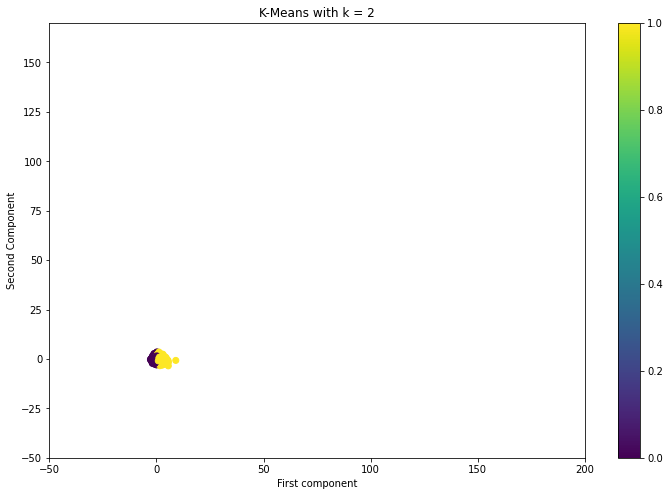

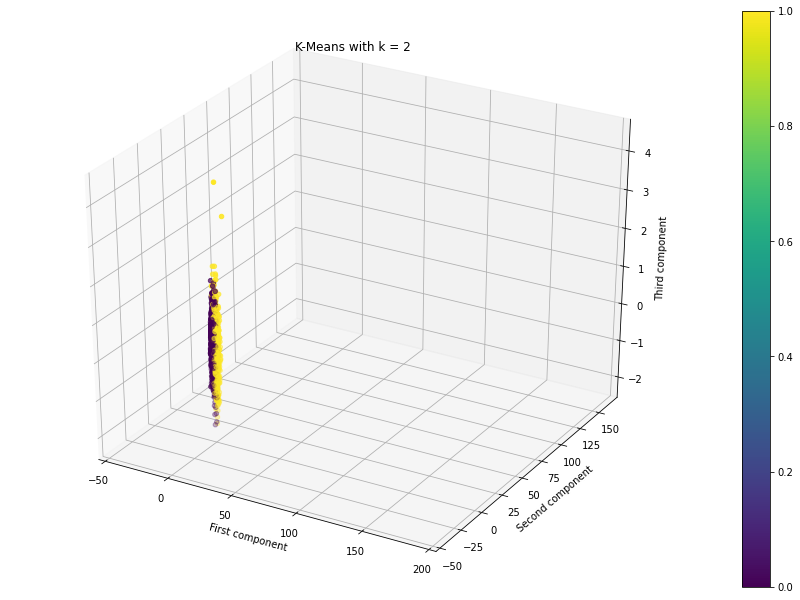

In [ ]:
from sklearn.decomposition import PCA

X_scaled_2D = PCA(n_components=2, random_state=42).fit_transform(X_scaled)
X_scaled_3D = PCA(n_components=3, random_state=42).fit_transform(X_scaled)

plot2D('K-Means with k = ' + str(k1), X_scaled_2D, X_preds_k1)
plot3D('K-Means with k = ' + str(k1), X_scaled_3D, X_preds_k1)

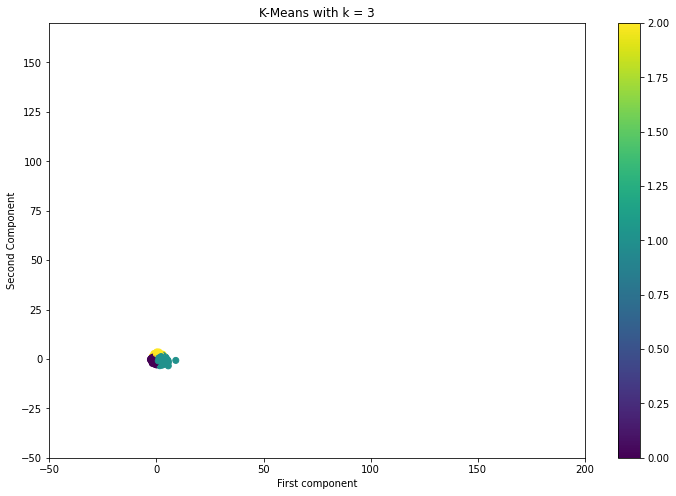

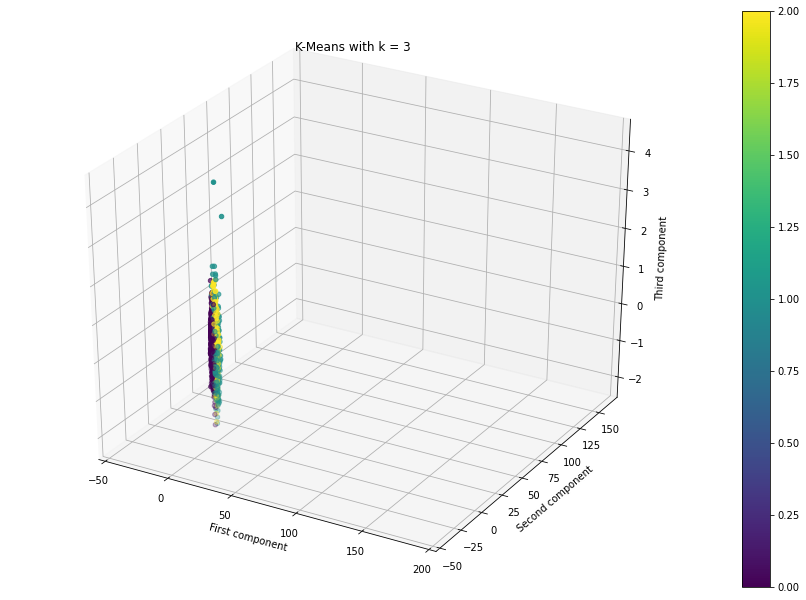

In [ ]:
plot2D('K-Means with k = ' + str(k2), X_scaled_2D, X_preds_k2)
plot3D('K-Means with k = ' + str(k2), X_scaled_3D, X_preds_k2)

### 5) Informe

Por último, deberán escribir un informe en el cual:
1. Muestren los clusters obtenidos en __3)__ como listas de canciones
2. Describan cualitativamente (e intuitivamente) estos clusters para cada __k__ elegido de acuerdo al contenido de los mismos, por ejemplo: 
    - El cluster 1 presenta canciones de géneros subsaharianos y es el más amplio debido a que..., el 2 de géneros tribales del cuerno de África, el 3...
    - Los clusters x0, x1, ... , xn no presentan algún patrón observable, pero xn+1 y xn+4 tienen...
4. Digan cuál k les dio resultados más coherentes y/o interpretables
5. Comparen los resultados obtenidos con aprendizaje no supervisado (con el mejor de los dos k) vs supervisado de manera cualitativa. Por ejemplo: nos parece mejor/peor/distinto/indistinto el modelo de aprendizaje no supervisado/supervisado en esta tarea porque...

---
Analizando los clusters obtenidos a partir de un k=2 y k=3 comprobamos que tenía mas sentido el agrupamiento que realizaba con k=2. 


Obteniendo las características de estos grupos podemos compararlos según las features con las que los agrupamos.

A partir de este analisis podemos deducir las siguientes afirmaciones:
* El género argentine rock es demasiado abarcativo para ser representativo, lo vemos presente en los dos grupos sin mostrar diferencias explícitas. Sumado a que en el dataset esta clase puede estar oversampleada.
* La clusterización logró agrupar en dos categorias muy evidentes:
  * En el cluster 0: Ritmos tropicales, correspondientes a los géneros de cuarteto y cumbia.
    * Son mas bailables en general
    * Tienden a ser mas energéticos
    * Y además son mas positivos y alegres que el otro grupo
  * En el cluster 1: Géneros indies o alternativos, mas cercanos al rock y al pop, de los géneros latin y argentine indie. Suelen ser no tan alegres, menos bailables y enérgicos.

In [ ]:
features.append('cluster')

In [ ]:
song_clusters_k1[features].groupby('cluster').describe().T

cluster                       0           1
danceability count  1016.000000  515.000000
             mean      0.616190    0.520986
             std       0.141550    0.156152
             min       0.172000    0.078000
             25%       0.530750    0.402500
             50%       0.635000    0.530000
             75%       0.718000    0.635000
             max       0.945000    0.902000
energy       count  1016.000000  515.000000
             mean      0.806878    0.572102
             std       0.109789    0.181419
             min       0.419000    0.033500
             25%       0.736750    0.455000
             50%       0.829000    0.575000
             75%       0.894000    0.690500
             max       0.995000    0.980000
loudness     count  1016.000000  515.000000
             mean     -5.167081   -8.865796
             std       1.660861    2.981538
             min     -10.958000  -28.480000
             25%      -6.265000  -10.309000
             50%      -5.118500   -8.232000
             75%      -3.970000   -6.939000
             max      -0.767000   -3.284000
valence      count  1016.000000  515.000000
             mean      0.730069    0.412386
             std       0.168009    0.190015
             min       0.145000    0.029200
             25%       0.620000    0.270000
             50%       0.758000    0.390000
             75%       0.863250    0.545500
             max       0.976000    0.928000

#### Cluster 0

In [ ]:
#CLUSTER 0 presenta canciones de los sgtes generos
song_clusters_k1[song_clusters_k1.cluster == 0].most_common_genre.value_counts()

argentine rock     389
cumbia villera     203
cuarteto           197
latin              158
argentine indie     69
Name: most_common_genre, dtype: int64

In [ ]:
song_clusters_k1[song_clusters_k1.cluster == 0].describe()

danceability       energy  ...  avg_lyrics_sentiment  cluster
count    1016.00000  1016.000000  ...           1016.000000   1016.0
mean        0.61619     0.806878  ...              0.488970      0.0
std         0.14155     0.109789  ...              0.035988      0.0
min         0.17200     0.419000  ...              0.000000      0.0
25%         0.53075     0.736750  ...              0.483375      0.0
50%         0.63500     0.829000  ...              0.504700      0.0
75%         0.71800     0.894000  ...              0.504700      0.0
max         0.94500     0.995000  ...              0.542900      0.0

[8 rows x 16 columns]

In [ ]:
song_clusters_k1[song_clusters_k1.cluster == 0]

danceability  energy  ...  avg_lyrics_sentiment  cluster
7            0.577   0.850  ...                0.4652        0
9            0.467   0.891  ...                0.4662        0
10           0.475   0.864  ...                0.5047        0
13           0.298   0.856  ...                0.5047        0
14           0.385   0.902  ...                0.5047        0
18           0.897   0.517  ...                0.5047        0
19           0.492   0.824  ...                0.5047        0
20           0.772   0.762  ...                0.5047        0
21           0.576   0.932  ...                0.4496        0
22           0.593   0.838  ...                0.5047        0
23           0.200   0.989  ...                0.5047        0
24           0.771   0.852  ...                0.4188        0
25           0.662   0.813  ...                0.5047        0
26           0.773   0.918  ...                0.5047        0
27           0.747   0.907  ...                0.3998        0
30           0.714   0.735  ...                0.4662        0
31           0.724   0.856  ...                0.4260        0
32           0.486   0.764  ...                0.4856        0
33           0.596   0.830  ...                0.3923        0
34           0.557   0.942  ...                0.5047        0
35           0.172   0.952  ...                0.4553        0
39           0.555   0.738  ...                0.5047        0
40           0.472   0.906  ...                0.5047        0
41           0.321   0.850  ...                0.5047        0
43           0.781   0.854  ...                0.5047        0
44           0.779   0.952  ...                0.5047        0
45           0.614   0.702  ...                0.5012        0
54           0.702   0.778  ...                0.5047        0
55           0.668   0.867  ...                0.5047        0
56           0.765   0.754  ...                0.4274        0
57           0.716   0.904  ...                0.5047        0
62           0.786   0.604  ...                0.4944        0
63           0.830   0.868  ...                0.5047        0
64           0.772   0.806  ...                0.4540        0
65           0.671   0.807  ...                0.5047        0
66           0.588   0.888  ...                0.4852        0
67           0.774   0.615  ...                0.5047        0
69           0.720   0.784  ...                0.4609        0
72           0.580   0.929  ...                0.4570        0
73           0.629   0.866  ...                0.5047        0
76           0.387   0.972  ...                0.4881        0
77           0.615   0.833  ...                0.4237        0
78           0.574   0.938  ...                0.4831        0
79           0.603   0.650  ...                0.5047        0
80           0.567   0.655  ...                0.5047        0
81           0.640   0.585  ...                0.5047        0
82           0.639   0.855  ...                0.5047        0
83           0.679   0.630  ...                0.5047        0
84           0.659   0.870  ...                0.5047        0
86           0.529   0.830  ...                0.5047        0
87           0.635   0.932  ...                0.5047        0
88           0.561   0.844  ...                0.5047        0
90           0.443   0.750  ...                0.5047        0
91           0.669   0.879  ...                0.5047        0
93           0.644   0.753  ...                0.5047        0
94           0.527   0.888  ...                0.5047        0
95           0.549   0.858  ...                0.5047        0
96           0.486   0.956  ...                0.5047        0
97           0.487   0.869  ...                0.5047        0
99           0.504   0.947  ...                0.5047        0
100          0.607   0.828  ...                0.5047        0
101          0.524   0.940  ...                0.5047        0
102          0.507   0.877  ...      

-----

#### Cluster 1

In [ ]:
#CLUSTER 1 presenta canciones de los sgtes generos
song_clusters_k1[song_clusters_k1.cluster == 1].most_common_genre.value_counts()

argentine rock     256
latin              107
argentine indie    102
cuarteto            36
cumbia villera      14
Name: most_common_genre, dtype: int64

In [ ]:
song_clusters_k1[song_clusters_k1.cluster == 1]

danceability  energy  ...  avg_lyrics_sentiment  cluster
3            0.499  0.6480  ...                0.4776        1
4            0.528  0.3830  ...                0.4901        1
5            0.330  0.5740  ...                0.4352        1
6            0.406  0.9470  ...                0.4828        1
29           0.485  0.7910  ...                0.4852        1
46           0.764  0.5210  ...                0.5047        1
49           0.765  0.2970  ...                0.5047        1
50           0.674  0.1160  ...                0.5047        1
51           0.805  0.4540  ...                0.5047        1
52           0.531  0.2770  ...                0.5047        1
58           0.504  0.6920  ...                0.5047        1
68           0.713  0.6820  ...                0.5047        1
70           0.616  0.7010  ...                0.4607        1
71           0.839  0.4480  ...                0.5047        1
74           0.586  0.7100  ...                0.4730        1
75           0.687  0.3870  ...                0.4976        1
85           0.457  0.7730  ...                0.5047        1
89           0.531  0.7730  ...                0.5047        1
92           0.627  0.6660  ...                0.5047        1
98           0.375  0.6980  ...                0.5047        1
104          0.653  0.4490  ...                0.5047        1
105          0.748  0.5950  ...                0.5047        1
113          0.512  0.3920  ...                0.5047        1
116          0.763  0.5970  ...                0.5047        1
132          0.739  0.4490  ...                0.5047        1
133          0.775  0.4610  ...                0.5047        1
134          0.717  0.4580  ...                0.5047        1
135          0.649  0.4100  ...                0.5047        1
137          0.675  0.5790  ...                0.5047        1
141          0.608  0.6720  ...                0.5047        1
142          0.647  0.5390  ...                0.5047        1
144          0.508  0.6900  ...                0.5047        1
147          0.432  0.5300  ...                0.5047        1
148          0.290  0.6810  ...                0.5047        1
156          0.735  0.6110  ...                0.5047        1
157          0.566  0.4630  ...                0.5047        1
159          0.304  0.7160  ...                0.5047        1
174          0.655  0.6290  ...                0.5047        1
179          0.577  0.5270  ...                0.5047        1
180          0.598  0.4890  ...                0.5047        1
184          0.475  0.7080  ...                0.5047        1
185          0.616  0.5040  ...                0.5047        1
186          0.593  0.4440  ...                0.5047        1
203          0.540  0.3670  ...                0.5047        1
204          0.641  0.5930  ...                0.5010        1
205          0.374  0.7270  ...                0.4781        1
207          0.401  0.4990  ...                0.4882        1
210          0.542  0.6650  ...                0.2949        1
211          0.610  0.6770  ...                0.4973        1
212          0.389  0.4430  ...                0.5029        1
213          0.516  0.6750  ...                0.5047        1
214          0.559  0.4290  ...                0.5047        1
215          0.501  0.6850  ...                0.5047        1
216          0.624  0.6950  ...                0.5047        1
217          0.669  0.5700  ...                0.4464        1
218          0.437  0.5220  ...                0.5025        1
220          0.486  0.6630  ...                0.4713        1
222          0.302  0.4280  ...                0.4980        1
223          0.483  0.5300  ...                0.5047        1
225          0.478  0.6610  ...                0.4703        1
228          0.571  0.5000  ...                0.5047        1
229          0.242  0.3340  ...                0.4827        1
230          0.451  0.6980  ...      

----

### Conclusión

Comparando el modelo supervisado de Random Forest binarios concatenados con el modelo no supervisado K Means con k igual a 2, podemos afirmar que los resultados obtenidos a partir del modelo supervisado son mejores y más representativos que el modelo no supervisado ya que nos permiten clasificar más específicamente cada canción desconocida en alguno de los 5 géneros más populares y propios del foco de análisis de la investigación. El modelo no supervisado, más allá de aportar un enfoque bastante acertado en la clusterización, si aumentamos la cantidad de clusters acercándonos al número de géneros que utilizamos como objetivo en el modelo supervisado, la clusterización es bastante imprecisa.
Estos resultados se pueden deber a distintas variables pero suponemos que son mejores los del modelo supervisado ya que este se adapta mejor a las features utilizadas, al desbalanceo presente en el dataset y a una característica muy importante que es la alta heterogeneidad dentro de un mismo género musical, algo que puede introducir ruido dentro del modelo no supervisado y que al modelo supervisado no afecta en gran medida.